<h1  style="font-size: 40px" align="center">Health Insurance Claim Analysis</h1> 

In [1]:
library(tidyverse)
library(caret)
library(scales)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor



In [2]:
data<-read.csv("insurance_data.csv")

In [3]:
head(data)

index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87
1,2,24,male,30.1,87,No,0,No,southeast,1131.51
2,3,NA,male,33.3,82,Yes,0,No,southeast,1135.94
3,4,NA,male,33.7,80,No,0,No,northwest,1136.40
4,5,NA,male,34.1,100,No,0,No,northwest,1137.01
5,6,NA,male,34.4,96,Yes,0,No,northwest,1137.47


In [4]:
sapply(data,function(x)sum(x == "" | is.na(x)))

index     PatientID           age        gender           bmi 
            0             0             5             0             0 
bloodpressure      diabetic      children        smoker        region 
            0             0             0             0             3 
        claim 
            0

In [5]:
data<-data%>%filter(region!="")%>%mutate(age = case_when(is.na(age) ~ median(.$age, na.rm=TRUE),TRUE ~ age))

In [6]:
print("The number of duplicates is :")
print(nrow(unique(data)) - nrow(data))

[1] "The number of duplicates is :"
[1] 0


In [7]:
data$age_bin <-cut(data$age, breaks = c(0, 18, 35, 55, Inf), 
            labels = c("Children", "Young Adults", "Adults", "Seniors"), 
            include.lowest = TRUE, 
            right = FALSE)

In [8]:
head(data)

index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,age_bin
0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87,Adults
1,2,24,male,30.1,87,No,0,No,southeast,1131.51,Young Adults
2,3,38,male,33.3,82,Yes,0,No,southeast,1135.94,Adults
3,4,38,male,33.7,80,No,0,No,northwest,1136.40,Adults
4,5,38,male,34.1,100,No,0,No,northwest,1137.01,Adults
5,6,38,male,34.4,96,Yes,0,No,northwest,1137.47,Adults


In [9]:
data$bmi_category <- cut(data$bmi, 
                       breaks = c(0, 18.5, 24.9, 30, Inf), 
                       labels = c("Underweight", "Normal weight", "Overweight", "Obese"), 
                       include.lowest = TRUE, 
                       right = TRUE)

In [10]:
head(data)

index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,age_bin,bmi_category
0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87,Adults,Normal weight
1,2,24,male,30.1,87,No,0,No,southeast,1131.51,Young Adults,Obese
2,3,38,male,33.3,82,Yes,0,No,southeast,1135.94,Adults,Obese
3,4,38,male,33.7,80,No,0,No,northwest,1136.40,Adults,Obese
4,5,38,male,34.1,100,No,0,No,northwest,1137.01,Adults,Obese
5,6,38,male,34.4,96,Yes,0,No,northwest,1137.47,Adults,Obese


# Exploratory Data Analysis

## Descriptive Statistics

In [11]:
print("The statistical summary of the dataset:")
print(summary(data[,3:ncol(data)]))

[1] "The statistical summary of the dataset:"
      age           gender         bmi        bloodpressure    diabetic 
 Min.   :18.00   female:662   Min.   :16.00   Min.   : 80.00   No :697  
 1st Qu.:29.00   male  :675   1st Qu.:26.20   1st Qu.: 86.00   Yes:640  
 Median :38.00                Median :30.40   Median : 92.00            
 Mean   :38.09                Mean   :30.67   Mean   : 94.17            
 3rd Qu.:47.00                3rd Qu.:34.70   3rd Qu.: 99.00            
 Max.   :60.00                Max.   :53.10   Max.   :140.00            
    children     smoker           region        claim               age_bin   
 Min.   :0.000   No :1063            :  0   Min.   : 1122   Children    :  0  
 1st Qu.:0.000   Yes: 274   northeast:231   1st Qu.: 4746   Young Adults:550  
 Median :1.000              northwest:349   Median : 9386   Adults      :662  
 Mean   :1.096              southeast:443   Mean   :13280   Seniors     :125  
 3rd Qu.:2.000              southwest:314   3rd 

In [12]:
cat("\nNumber of rows: ",nrow(data),"\n")
cat("\nNumber of columns: ",ncol(data),"\n")

cat("\nColumn names:")
print(colnames(data))

cat("\nThe mean age of the dataset is",round(mean(data$age, na.rm = TRUE),0))


Number of rows:  1337 

Number of columns:  13 

Column names: [1] "index"         "PatientID"     "age"           "gender"       
 [5] "bmi"           "bloodpressure" "diabetic"      "children"     
 [9] "smoker"        "region"        "claim"         "age_bin"      
[13] "bmi_category" 

The mean age of the dataset is 38

## Gender Exploration 

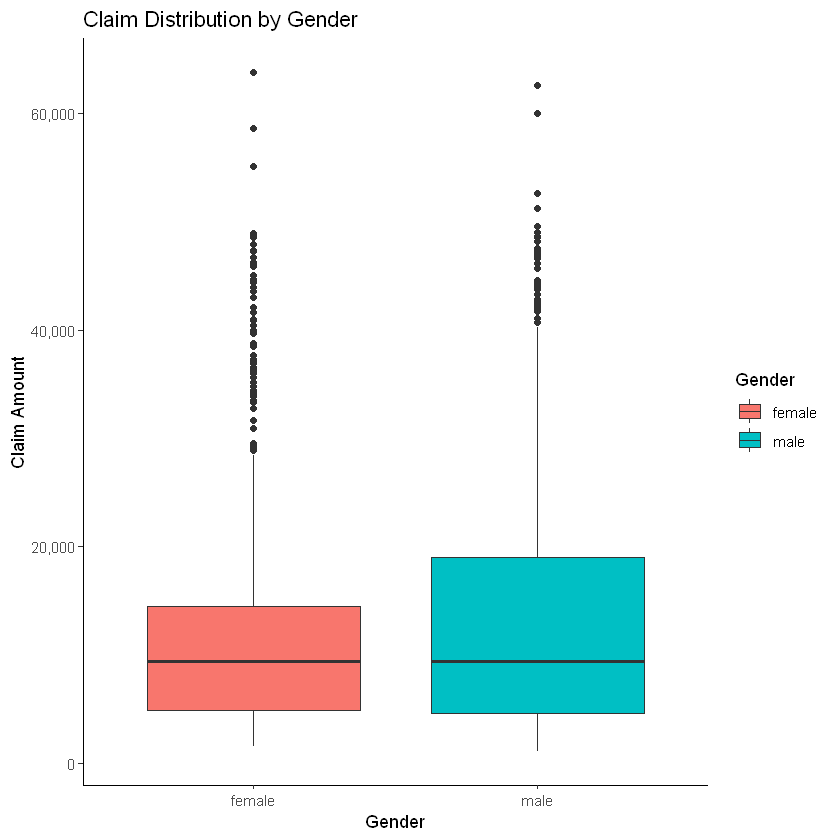

In [13]:
data%>% 
  ggplot(aes(x = gender, y = claim, fill = gender)) +
  geom_boxplot() +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by Gender", x = "Gender", 
       y = "Claim Amount", fill = "Gender") +
  theme_classic()


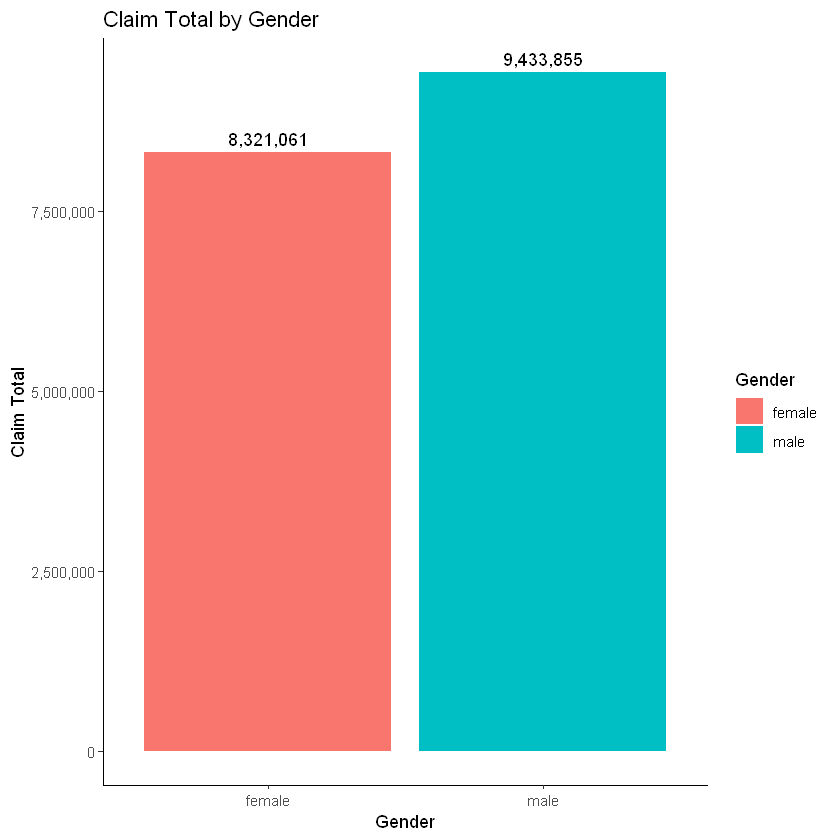

In [14]:
gender_claim_summary_data <- data %>%
  group_by(gender) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

gender_claim_summary_data %>%
  ggplot(aes(x=gender, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=gender)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Total by Gender", x = "Gender", 
       y = "Claim Total", fill = "Gender") +
  theme_classic()

In [15]:
print("We can observe the male patients have higher claim amounts than female patients.")

[1] "We can observe the male patients have higher claim amounts than female patients."


## Age Exploration 

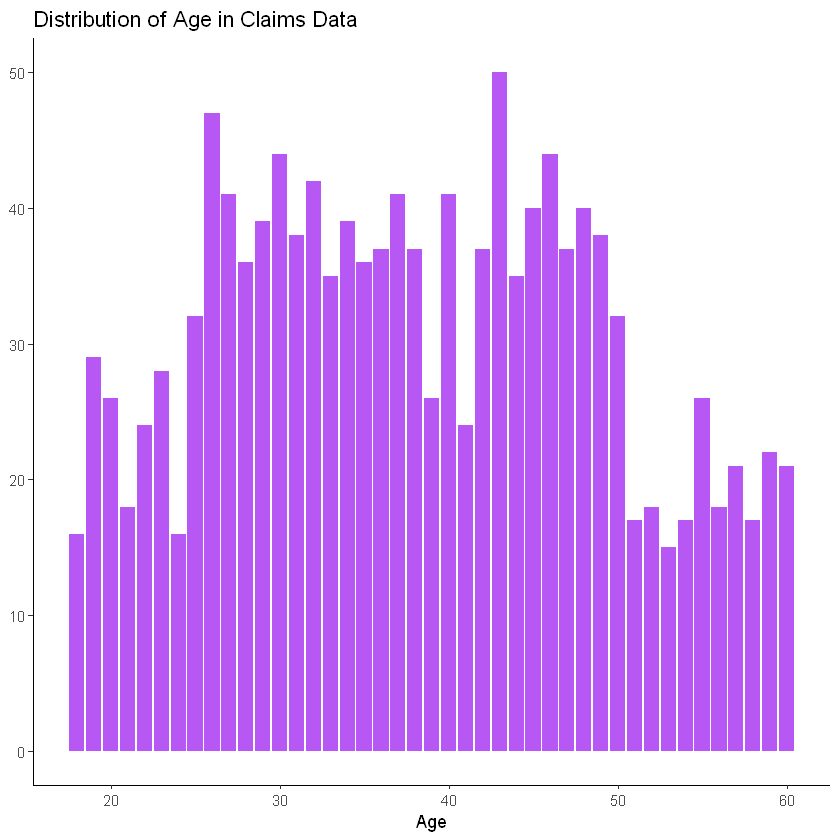

In [16]:
data %>% 
  ggplot(aes(x=age)) +
  geom_bar(fill = "purple", alpha = 0.75) +
  labs(title = "Distribution of Age in Claims Data",
       x = "Age", y = NULL) +
  theme_classic()

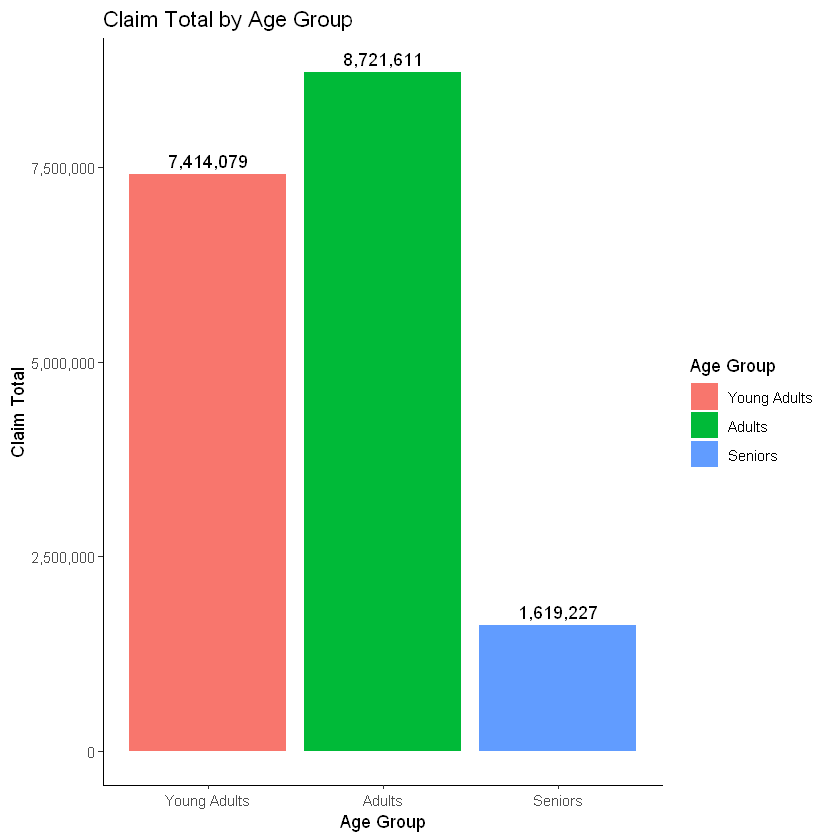

In [17]:
age_claim_summary_data <- data %>%
  group_by(age_bin) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

age_claim_summary_data %>%
  ggplot(aes(x=age_bin, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=age_bin)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Total by Age Group", x ="Age Group",
       y = "Claim Total", fill = "Age Group") +
  theme_classic()

[1] "We can observe higher claims of Young Adults and Adults than Seniors, but the distribution of the claim amounts seems to \n       be similar between the age groups."


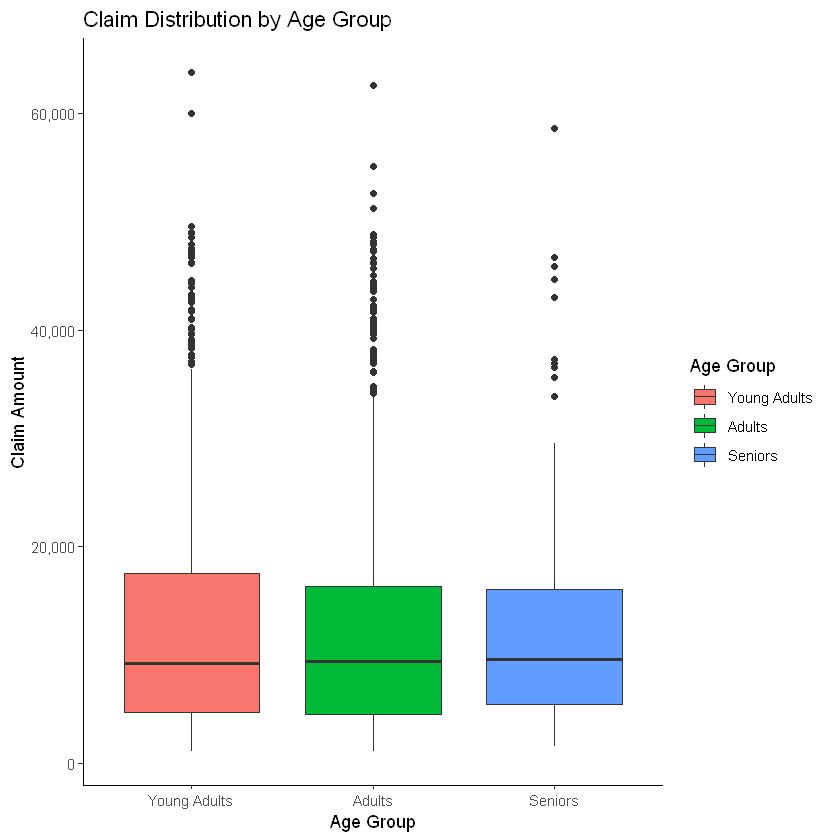

In [18]:
data %>% 
  ggplot(aes(x=age_bin,y=claim)) + 
  geom_boxplot(aes(fill = age_bin)) +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by Age Group", x ="Age Group",
       y = "Claim Amount", fill = "Age Group") +
  theme_classic()

print("We can observe higher claims of Young Adults and Adults than Seniors, but the distribution of the claim amounts seems to 
       be similar between the age groups.")

## BMI Exploration

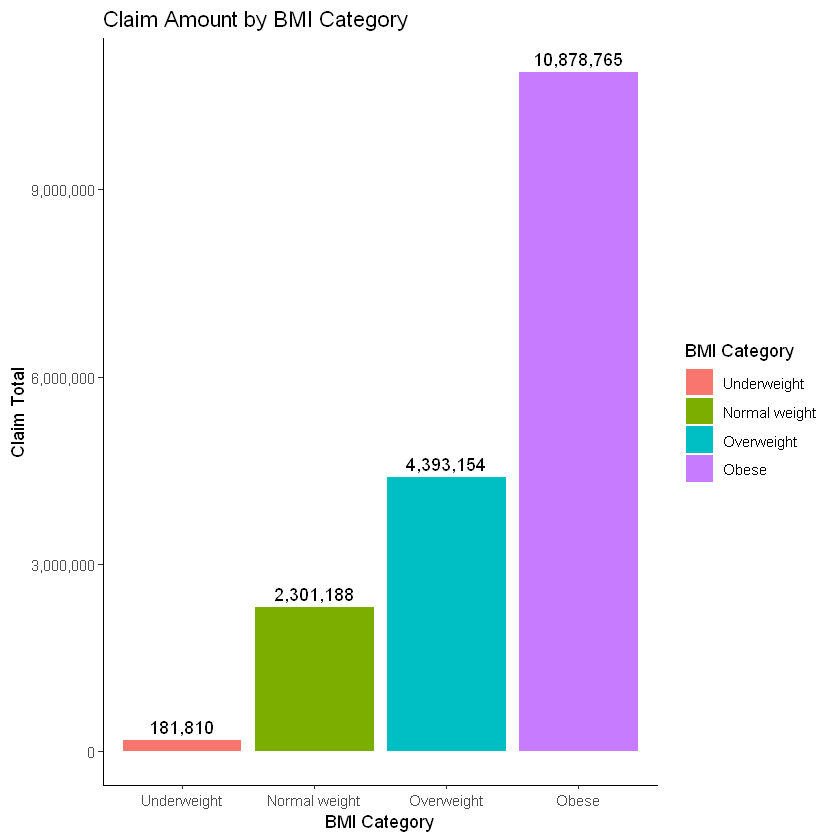

In [19]:
bmi_claim_summary_data <- data %>%
  group_by(bmi_category) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

bmi_claim_summary_data %>%
  ggplot(aes(x=bmi_category, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=bmi_category)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Amount by BMI Category", x ="BMI Category",
       y = "Claim Total", fill = "BMI Category") +
  theme_classic()

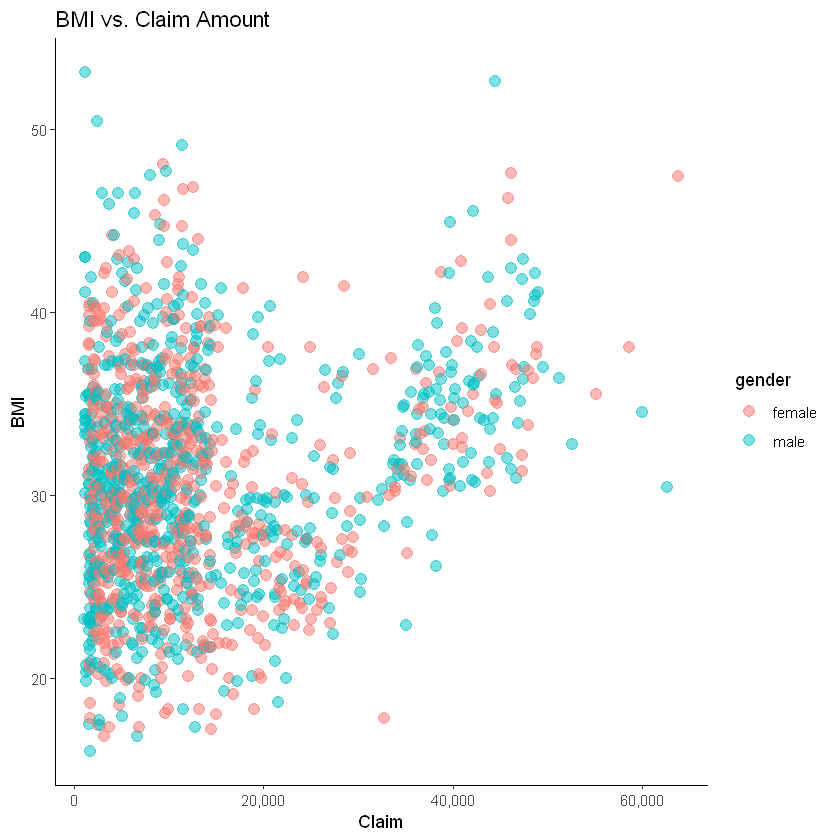

In [20]:
data %>% 
  ggplot(aes(x = claim, y = bmi, color = gender)) + 
  geom_point(alpha = 0.5, size = 3) + 
  scale_x_continuous(labels = comma) +
  labs(title = "BMI vs. Claim Amount", x = "Claim",  y = "BMI")+
  theme_classic()

[1] "We can observe higher claim amounts in Obese patients."


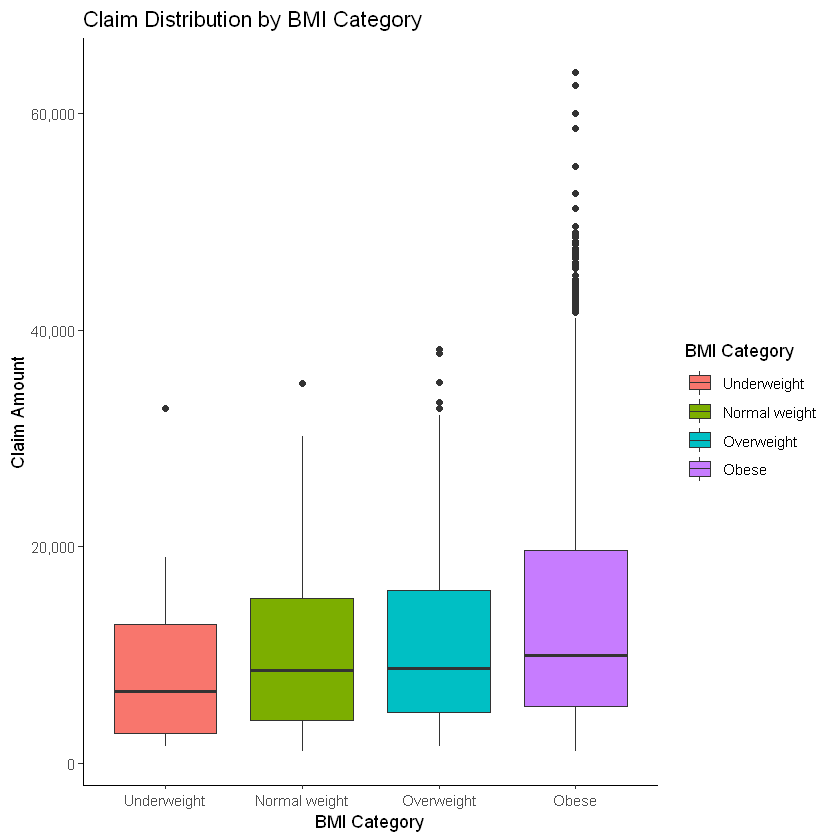

In [21]:
data %>% 
  ggplot(aes(x=bmi_category,y=claim)) + 
  geom_boxplot(aes(fill = bmi_category)) +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by BMI Category", x ="BMI Category",
       y = "Claim Amount", fill = "BMI Category") +
  theme_classic()

print("We can observe higher claim amounts in Obese patients.")

## Smoker Explorations 

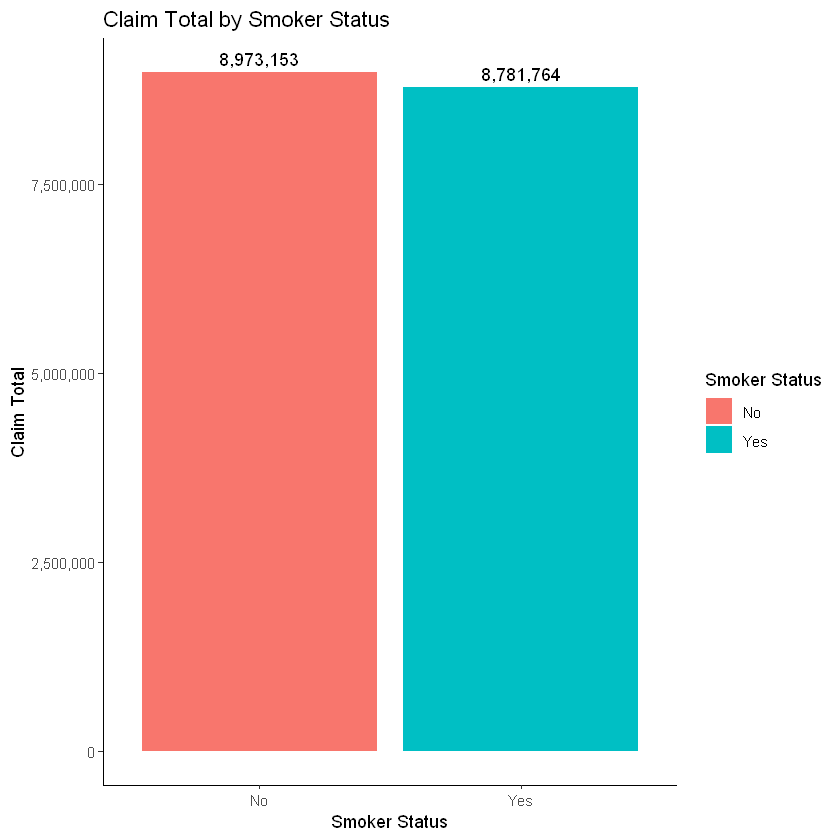

In [22]:
smoker_claim_summary_data <- data %>%
  group_by(smoker) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

smoker_claim_summary_data %>%
  ggplot(aes(x=smoker, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=smoker)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Total by Smoker Status", x ="Smoker Status",
       y = "Claim Total", fill = "Smoker Status") +
  theme_classic()

[1] "We can observe higher claim amounts in Smoker patients."


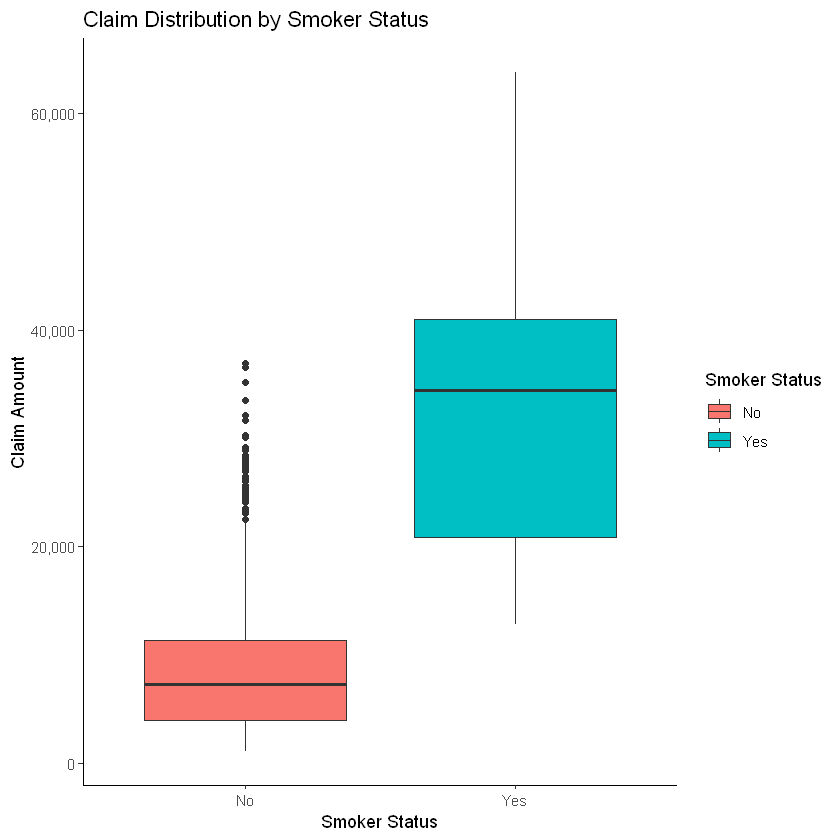

In [23]:
data %>% 
  ggplot(aes(x=smoker,y=claim)) + 
  geom_boxplot(aes(fill = smoker)) +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by Smoker Status", x ="Smoker Status",
       y = "Claim Amount", fill = "Smoker Status") +
  theme_classic()

print("We can observe higher claim amounts in Smoker patients.")

## Diabetic Exploration

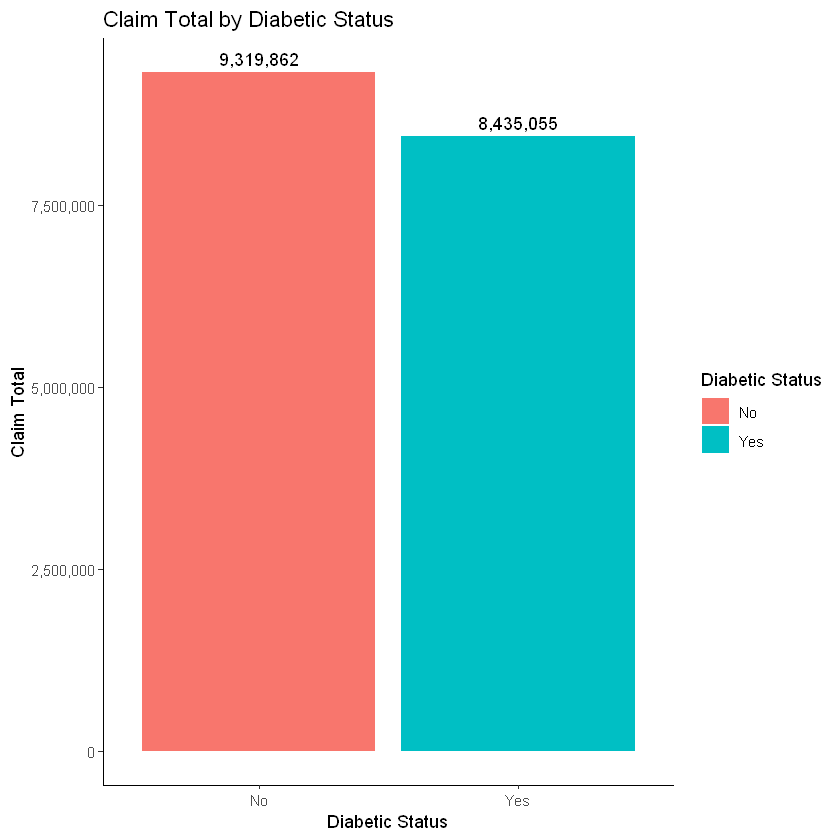

In [24]:
diabetic_claim_summary_data <- data %>%
  group_by(diabetic) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

diabetic_claim_summary_data %>%
  ggplot(aes(x=diabetic, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=diabetic)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Total by Diabetic Status", x ="Diabetic Status",
       y = "Claim Total", fill = "Diabetic Status") +
  theme_classic()

[1] "We can observe that there is not significant difference in claim amounts of Diabetic and Non-Diabetic patients."


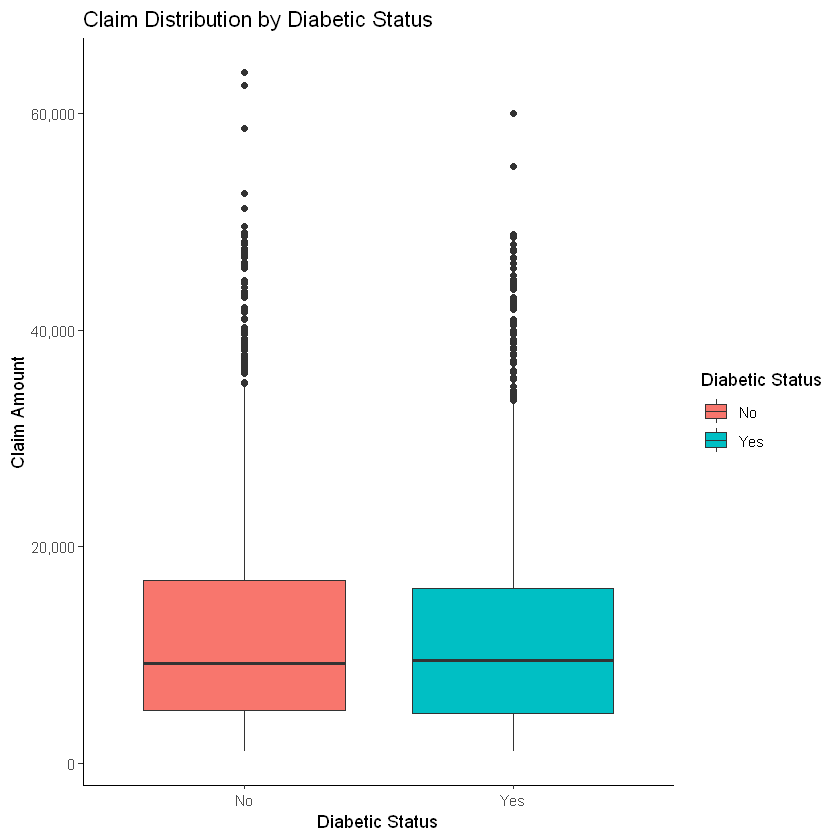

In [25]:
data %>% 
  ggplot(aes(x=diabetic,y=claim)) + 
  geom_boxplot(aes(fill = diabetic)) +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by Diabetic Status", x ="Diabetic Status",
       y = "Claim Amount", fill = "Diabetic Status") +
  theme_classic()

print("We can observe that there is not significant difference in claim amounts of Diabetic and Non-Diabetic patients.")

## Region Exploration

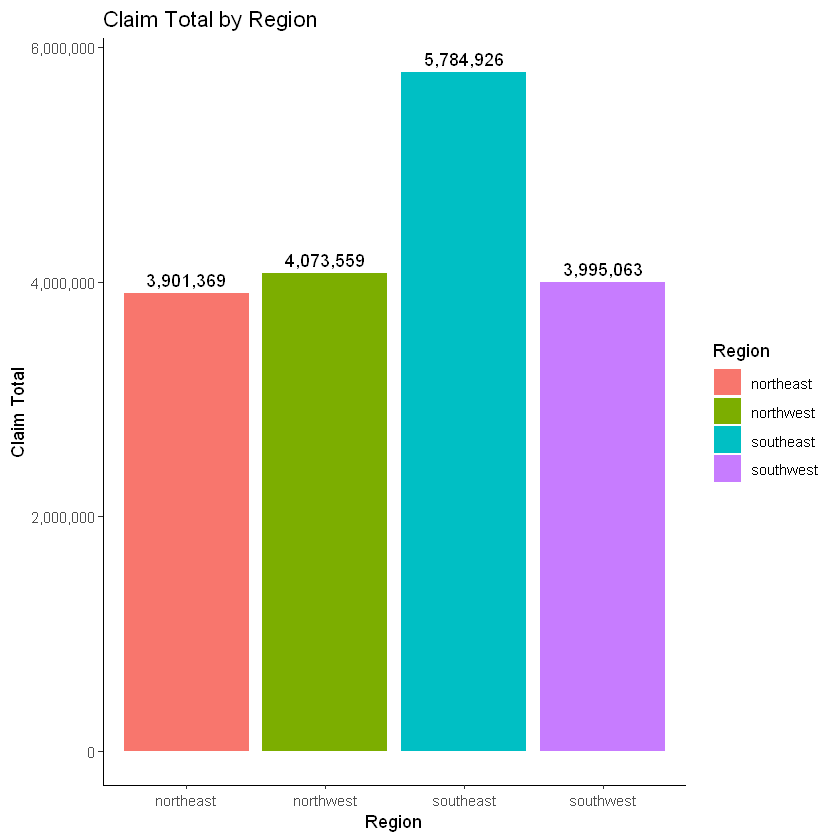

In [26]:
region_claim_summary_data <- data %>%
  group_by(region) %>%
  summarise(claim_total = sum(claim, na.rm = TRUE))

region_claim_summary_data %>%
  ggplot(aes(x=region, y=claim_total)) +
  geom_bar(stat="identity", aes(fill=region)) + 
  scale_y_continuous(labels = comma) +
  geom_text(aes(label=comma(claim_total)), vjust=-0.5) +
  labs(title = "Claim Total by Region", x ="Region",
       y = "Claim Total", fill = "Region") +
  theme_classic() 

[1] "We can observe higher claim amounts in patients from the norththeast region."


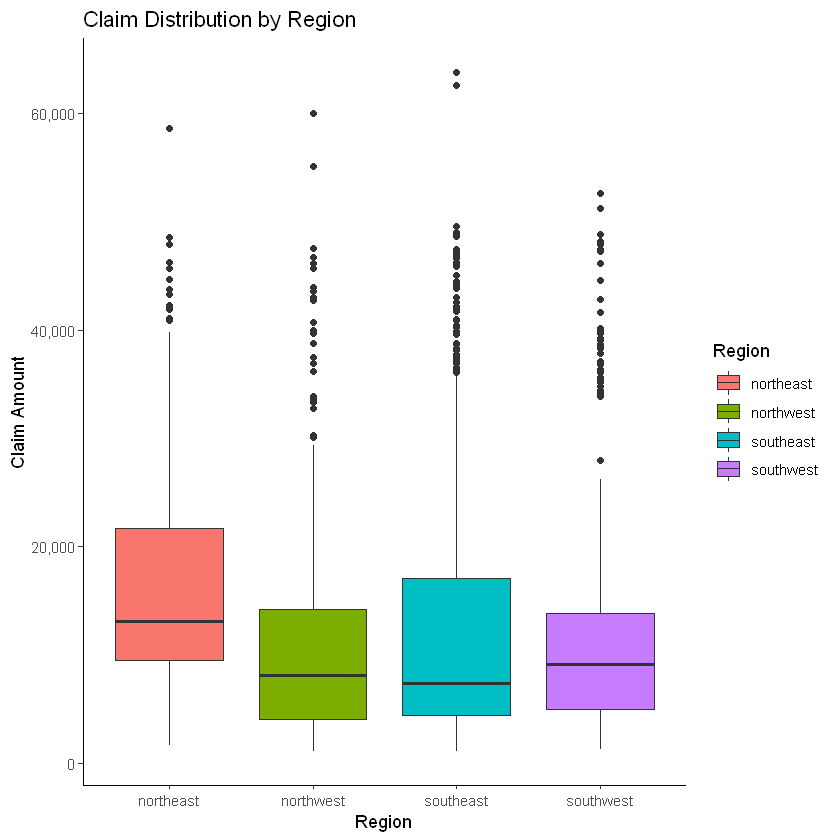

In [27]:
data %>% 
  ggplot(aes(x=region,y=claim)) + 
  geom_boxplot(aes(fill = region)) +
  scale_y_continuous(labels = comma) +
  labs(title = "Claim Distribution by Region", x ="Region",
       y = "Claim Amount", fill = "Region") +
  theme_classic()

print("We can observe higher claim amounts in patients from the norththeast region.")

Through data exploration, we have observed that the gender, BMI, smoker status and region attributes seem to have an effect in the claim amount of a patient. To test these hypothesis, we will proceed to perform statistical tests such as T-Test and ANOVA to determine its validity. We will also include diabetic status in these tests

# Statistical Tests

## T-Test 

### Gender

In [28]:
gender_t_result <- t.test(data$claim[data$gender == 'female'], data$claim[data$gender == 'male'])
print(gender_t_result)

cat("Given the result of the T-Test and a p-value of",gender_t_result$p.value,", 
      we can conclude that there is a difference in claim amounts for each gender.")


	Welch Two Sample t-test

data:  data$claim[data$gender == "female"] and data$claim[data$gender == "male"]
t = -2.1293, df = 1311.9, p-value = 0.03342
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2702.3627  -110.6433
sample estimates:
mean of x mean of y 
 12569.58  13976.08 

Given the result of the T-Test and a p-value of 0.03341735 , 
      we can conclude that there is a difference in claim amounts for each gender.

### Smoker

In [29]:
smoker_t_result <- t.test(data$claim[data$smoker == 'Yes'], data$claim[data$smoker == 'No'])
print(smoker_t_result)
cat("Given the result of the T-Test and a p-value of",smoker_t_result$p.value,", 
     we can conclude that there is a difference in claim amounts for smokers.")


	Welch Two Sample t-test

data:  data$claim[data$smoker == "Yes"] and data$claim[data$smoker == "No"]
t = 32.742, df = 311.87, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 22190.11 25027.65
sample estimates:
mean of x mean of y 
32050.232  8441.348 

Given the result of the T-Test and a p-value of 6.316764e-103 , 
     we can conclude that there is a difference in claim amounts for smokers.

### Diabetic

In [30]:
diabetic_t_result <- t.test(data$claim[data$diabetic == 'Yes'], data$claim[data$diabetic == 'No'])
print(diabetic_t_result)
cat("Given the result of the T-Test and a p-value of",diabetic_t_result$p.value,", 
     we can conclude that there is no difference in claim amounts for diabetic patients.")


	Welch Two Sample t-test

data:  data$claim[data$diabetic == "Yes"] and data$claim[data$diabetic == "No"]
t = -0.28928, df = 1330.6, p-value = 0.7724
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1491.100  1107.857
sample estimates:
mean of x mean of y 
 13179.77  13371.39 

Given the result of the T-Test and a p-value of 0.772412 , 
     we can conclude that there is no difference in claim amounts for diabetic patients.

## ANOVA and post-hoc Tukey 

In [31]:
bmi_anova_result <- aov(claim ~ bmi_category, data = data)
summary(bmi_anova_result)
bmi_tukey_posthoc <- TukeyHSD(bmi_anova_result, "bmi_category")
print(bmi_tukey_posthoc)
print("We can observe significant differences for the Obese BMI catgory")

               Df    Sum Sq   Mean Sq F value   Pr(>F)    
bmi_category    3 7.937e+09 2.646e+09   18.76 6.38e-12 ***
Residuals    1333 1.880e+11 1.410e+08                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = claim ~ bmi_category, data = data)

$bmi_category
                               diff        lwr       upr     p adj
Normal weight-Underweight 1708.0880 -5265.8830  8682.059 0.9224018
Overweight-Underweight    2436.2009 -4404.0799  9276.482 0.7962491
Obese-Underweight         6928.0023   162.6529 13693.352 0.0423675
Overweight-Normal weight   728.1128 -1833.0270  3289.253 0.8845461
Obese-Normal weight       5219.9142  2866.2048  7573.624 0.0000001
Obese-Overweight          4491.8014  2570.0531  6413.550 0.0000000

[1] "We can observe significant differences for the Obese BMI catgory"


In [32]:
region_anova_result <- aov(claim ~ region, data = data)
summary(region_anova_result)

region_anova_result <- aov(claim ~ region, data = data)
tukey_posthoc <- TukeyHSD(region_anova_result, "region")
print(tukey_posthoc)

print("We can observe significant differences for the northeast region.")

              Df    Sum Sq   Mean Sq F value   Pr(>F)    
region         3 4.030e+09 1.343e+09   9.332 4.16e-06 ***
Residuals   1333 1.919e+11 1.440e+08                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = claim ~ region, data = data)

$region
                          diff        lwr       upr     p adj
northwest-northeast -5216.9563 -7834.6893 -2599.223 0.0000020
southeast-northeast -3830.5221 -6335.2016 -1325.843 0.0005092
southwest-northeast -4165.9149 -6841.1226 -1490.707 0.0003795
southeast-northwest  1386.4342  -822.4761  3595.345 0.3707069
southwest-northwest  1051.0414 -1349.5005  3451.583 0.6733671
southwest-southeast  -335.3928 -2612.1217  1941.336 0.9814677

[1] "We can observe significant differences for the northeast region."


## Conclusion 1

Through Exploratory Data Analysis and Statistical Tests, we have reached the conclusion that the variables in our dataset that have a statistical significant effect on claim amounts are:
<ul>
<li>Gender, with male patients having higher claims than female patients;
<li>Smoker status, with smoker patients having higher claims than non-smoker patients;
<li>BMI, with those who fall in the Obese category having higher claims; and
<li>Region, with those from the northeast region having higher claims than those from the other regions.

# Model Selection

In [33]:
data.1<-data %>% 
  mutate(gender_male = ifelse(gender == "male", 1, 0),
         smoker_yes = ifelse(smoker == "Yes", 1, 0),
         diabetic_yes = ifelse(diabetic == "Yes", 1, 0))%>%
         unite("region", region) %>%
         spread(region, region, fill = 0)

In [34]:
head(data.1)

index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,claim,age_bin,bmi_category,gender_male,smoker_yes,diabetic_yes,northeast,northwest,southeast,southwest
0,1,39,male,23.2,91,Yes,0,No,1121.87,Adults,Normal weight,1,0,1,0,0,southeast,0
1,2,24,male,30.1,87,No,0,No,1131.51,Young Adults,Obese,1,0,0,0,0,southeast,0
2,3,38,male,33.3,82,Yes,0,No,1135.94,Adults,Obese,1,0,1,0,0,southeast,0
3,4,38,male,33.7,80,No,0,No,1136.40,Adults,Obese,1,0,0,0,northwest,0,0
4,5,38,male,34.1,100,No,0,No,1137.01,Adults,Obese,1,0,0,0,northwest,0,0
5,6,38,male,34.4,96,Yes,0,No,1137.47,Adults,Obese,1,0,1,0,northwest,0,0


### Splitting data into testing and training set 

In [35]:
set.seed(123)

trainIndex <- createDataPartition(data.1$claim, p = 0.7, list = FALSE)
train_set <- data.1[trainIndex, ]
test_set <- data.1[-trainIndex, ]

### Baseline 

In [36]:
mean_claim_train <- mean(train_set$claim)
baseline_predictions <- rep(mean_claim_train, length(test_set$claim))

residuals_baseline <- test_set$claim - baseline_predictions

mse_baseline <- mean(residuals_baseline^2)
rmse_baseline <- sqrt(mse_baseline)

print(paste("Baseline Mean Squared Error (MSE):", mse_baseline))
print(paste("Baseline Root Mean Squared Error (RMSE):", rmse_baseline))

[1] "Baseline Mean Squared Error (MSE): 159539113.49701"
[1] "Baseline Root Mean Squared Error (RMSE): 12630.8793635681"


### Model Training  

In [37]:
model <- lm(claim ~ age + gender_male + bmi + smoker_yes + diabetic_yes + northeast + northwest + southeast, data = train_set)

model_summary <- summary(model)

print(paste("R-squared:", model_summary$r.squared))
print(paste("Adjusted R-squared:", model_summary$adj.r.squared))

[1] "R-squared: 0.645388996041813"
[1] "Adjusted R-squared: 0.642332004628381"


In [38]:
test_pred <- predict(model, newdata = test_set)

mse <- mean((test_set$claim - test_pred)^2)
rmse <- sqrt(mse)

print(paste("Mean Squared Error (MSE) on Test Set:", mse))
print(paste("Root Mean Squared Error (RMSE) on Test Set:", rmse))

[1] "Mean Squared Error (MSE) on Test Set: 47218615.2133241"
[1] "Root Mean Squared Error (RMSE) on Test Set: 6871.58025590359"


## Conclusion 2 

While there is certainly a lot of room for growth in improving our model, comparing the results of our model to the baseline, we can see a significant improvement in the predictions of linear the regression model.

With an R-square value of 0.645 and an adjusted R-square value of 0.642, we found that 64.5% of the variation in claim amount could be explained by our predictors. Since both values are very close, we can conclude that most of the variables included in the model are reasonable predictors. This is a strong preliminary result, especially considering the typical complexity of health data.